### **Load libraries**

In [1]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
allocated_index = pd.read_csv('../temp_references/allocated_index.csv', index_col=0)
allocated_index_returns = pd.read_csv('../temp_references/allocated_index_returns.csv', index_col=0)

In [5]:
expected_returns = pd.read_csv('../temp_references/expected_returns.csv', index_col=0, header=None).iloc[:,0]
expected_covmat = pd.read_csv('../temp_references/expected_covmat.csv', index_col=0)

In [6]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

### **Potential stock evolution modeled as a Brownian Motion**

In [7]:
summary_stats = rk.summary_stats(allocated_index_returns, periods_per_year=periods_per_year, riskfree_rate=0)
# Based on historical returns
index_mu = summary_stats['Annualized Return']['index']
index_sigma = summary_stats['Annualized Volatility']['index']

# Based on predicted returns
index_mu

(index_mu.round(4), index_sigma.round(4))

(0.1246, 0.1328)

In [8]:
summary_stats

,Annualized Return,Annualized Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
PBR,0.262380,0.521944,0.721840,11.663530,0.082337,0.140307,0.502697,-0.710030
PFE,0.028068,0.242325,0.153957,4.900353,0.050463,0.070859,0.115828,-0.571144
SGLD.L,0.149996,0.145504,0.113471,5.008106,0.028336,0.039937,1.030874,-0.194443
SUAS.L,0.138203,0.167425,-0.549797,10.008602,0.035023,0.051167,0.825466,-0.293075
CBU7.L,0.016984,0.040521,0.216750,6.046442,0.008059,0.012274,0.419155,-0.140871
index,0.124567,0.132802,-0.854277,9.409311,0.029188,0.041206,0.937985,-0.246385


In [9]:
cppi_controls = widgets.interactive(rk.show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50, description='Number of scenarios'),
                                    n_years=widgets.IntSlider(min=1, max=30, step=1, value=10, description='Number of years'),
                                    steps_per_year=widgets.IntSlider(min=1, max=252, step=1, value=12, description='Rebals/year'),
                                    mu=(-.2, .6, .01),
                                    sigma=(0, .6, .01),
                                    floor=(0, 2, .05),
                                    riskfree_rate=(0, .2, .01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,
                                                            description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='Number of scenarios', max=1000, min=1, step=5), IntSlid…

### **Develop Drawdown-based CPPI Strategy (Constant Proportion Portfolio Insurance)**

In [10]:
# Run a backtest for the allocated index with a drawdown-based CPPI strategy
drawdown_floor = .2
rf_rate = .11
m = 5

btr = rk.run_cppi(allocated_index_returns, m=m, start=1000, riskfree_rate=rf_rate, drawdown=drawdown_floor)

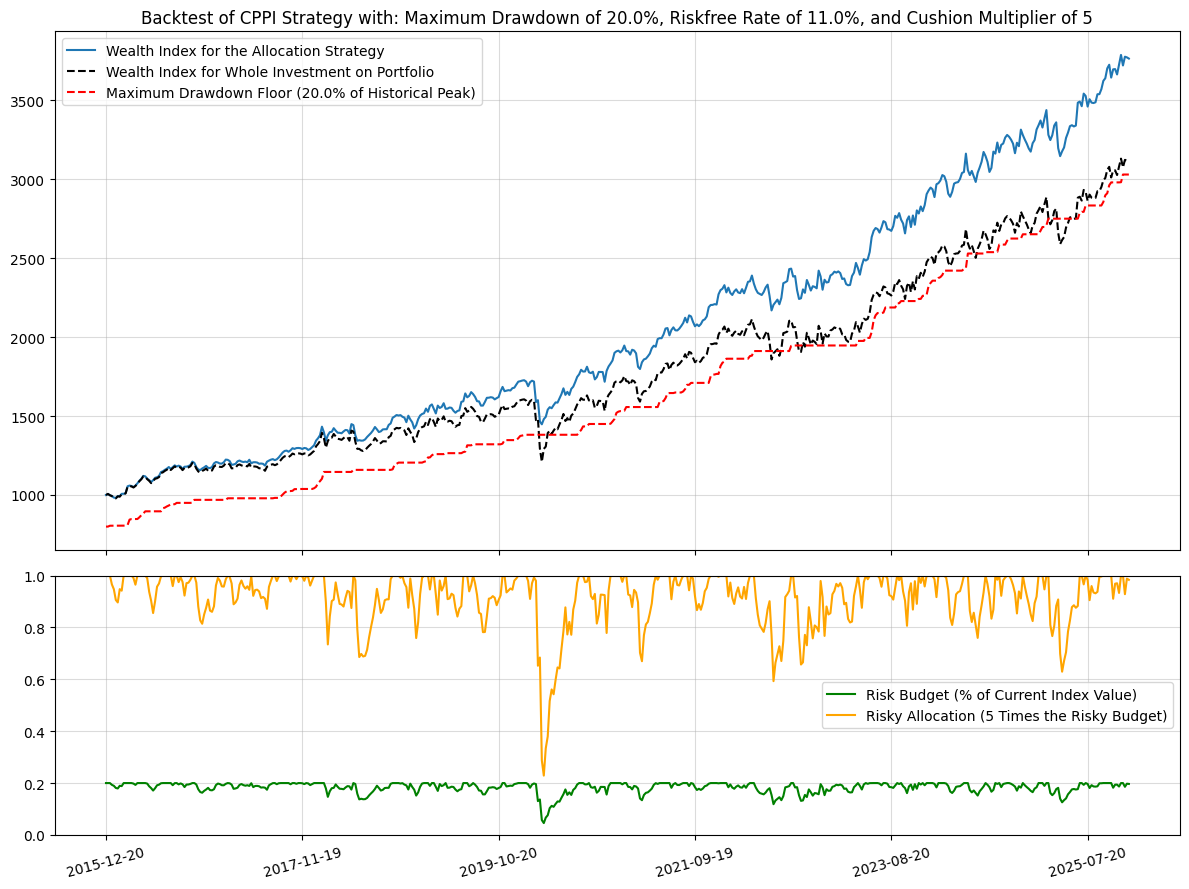

In [11]:
# Visualize the backtest of the CPPI strategy
# First subplot
fig, axes = plt.subplots(2, 1, figsize=(12, 9), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
btr['Wealth']['index'].plot(ax=axes[0], label='Wealth Index for the Allocation Strategy')
btr['Risky Wealth']['index'].plot(ax=axes[0], style='k--', label='Wealth Index for Whole Investment on Portfolio')
btr['floor']['index'].plot(ax=axes[0], color='r', linestyle='--', label=f'Maximum Drawdown Floor ({drawdown_floor*100}% of Historical Peak)')

# Second subplot
btr['Risk Budget']['index'].plot(ax=axes[1], color='g', label='Risk Budget (% of Current Index Value)')
btr['Risky Allocation']['index'].plot(ax=axes[1], color='orange', label=f'Risky Allocation ({m} Times the Risky Budget)')

axes[0].set_title(f'Backtest of CPPI Strategy with: Maximum Drawdown of {drawdown_floor*100}%, Riskfree Rate of {rf_rate*100}%, and Cushion Multiplier of {m}')

axes[0].legend()
axes[1].legend()

axes[0].grid(alpha=.45)
axes[1].grid(alpha=.45)

axes[1].set_ylim(0, 1)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### **Recommended Allocation based on last week**

In [12]:
btr['Wealth']

,PBR,PFE,SGLD.L,SUAS.L,CBU7.L,index
2015-12-20,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-12-27,1041.379699,1019.694036,1006.452567,1000.000000,998.802261,1006.813214
2016-01-03,988.505932,1009.065404,994.837961,1000.000000,997.078821,998.257159
2016-01-10,891.059618,971.128532,1034.358181,1000.000000,1006.206736,993.714130
2016-01-17,859.479564,968.147689,1019.085280,1000.000000,1012.567326,983.656763
...,...,...,...,...,...,...
2025-11-16,19750.565904,3373.434877,5432.445221,4293.348031,1438.707221,3785.873220
2025-11-23,19140.250677,3379.569297,5414.676021,4203.117730,1444.630877,3719.037380
2025-11-30,18886.985146,3457.864444,5573.183958,4322.729920,1447.356829,3774.571650
2025-12-07,18433.524001,3495.671775,5580.572186,4410.073218,1442.106887,3770.311454


In [13]:
weights = (allocated_index.iloc[0]/allocated_index['index'][0]).drop('index', axis='index')
investment = 82000000 # Current money available for investment in COP

stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights
safe_allocation = (1 - btr['Risky Allocation']['index'][-1])*investment

C:\Users\jumar\AppData\Local\Temp\ipykernel_16712\2076876111.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = (allocated_index.iloc[0]/allocated_index['index'][0]).drop('index', axis='index')
C:\Users\jumar\AppData\Local\Temp\ipykernel_16712\2076876111.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights
C:\Users\jumar\AppData\Local\Temp\ipykernel_16712\2076876111.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Dat

In [14]:
# Amount allocated in risky assets
(stocks_allocation/1000).round(2)

PBR        6838.84
PFE        9925.39
SGLD.L    15494.25
SUAS.L    24193.86
CBU7.L    24193.86
Name: 2015-12-13, dtype: float64

In [15]:
# Amount allocated in safe assets
(safe_allocation/1000).round(2)

1353.8

In [16]:
# Allocation if all budget went to the risky investment

stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights + (1 - btr['Risky Allocation']['index'][-1])*investment*weights
(stocks_allocation/1000).round(2)

C:\Users\jumar\AppData\Local\Temp\ipykernel_16712\1100804839.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stocks_allocation = btr['Risky Allocation']['index'][-1]*investment*weights + (1 - btr['Risky Allocation']['index'][-1])*investment*weights


PBR        6953.64
PFE       10092.01
SGLD.L    15754.35
SUAS.L    24600.00
CBU7.L    24600.00
Name: 2015-12-13, dtype: float64